In [1]:
from itertools import product
import math
import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy import stats

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Useful directory path.
root_dir = f'{os.getcwd()}/../results'
graphics_dir = f'{root_dir}/graphics'

# GP tools.
tools = ('DEAP', 'TensorGP (CPU)', 'TensorGP (GPU)', 'Operon', 'FPGA')

# Function sets.
function_sets = {
    'nicolau_a': (4, 9, 1023, 32),
    'nicolau_b': (6, 7, 255, 8),
    'nicolau_c': (9, 6, 127, 4)
}

# Numbers of fitness cases.
num_fitness_cases = (10, 100, 1000, 10000, 100000)

# Number of programs per size bin.
nppsb = 128

# Program dictionary.
with open(f'{root_dir}/programs/programs.pkl', 'rb') as f:
    program_dict = pickle.load(f) 

Function counts, bin 0: [270, 257, 256, 234]
Function counts, bin 1: [790, 821, 769, 769]
Function counts, bin 2: [1248, 1304, 1260, 1277]
Function counts, bin 3: [1770, 1784, 1813, 1797]
Function counts, bin 4: [2258, 2339, 2291, 2356]
Function counts, bin 5: [2860, 2835, 2828, 2840]
Function counts, bin 6: [3302, 3405, 3336, 3322]
Function counts, bin 7: [3860, 3923, 3751, 3826]
Function counts, bin 8: [4305, 4352, 4335, 4426]
Function counts, bin 9: [4919, 4964, 4786, 4808]
Function counts, bin 10: [5339, 5407, 5416, 5382]
Function counts, bin 11: [5960, 5929, 5829, 5823]
Function counts, bin 12: [6433, 6373, 6374, 6392]
Function counts, bin 13: [6956, 6864, 6812, 7055]
Function counts, bin 14: [7400, 7301, 7490, 7382]
Function counts, bin 15: [7898, 7872, 8081, 7876]
Function counts, bin 16: [8510, 8368, 8421, 8470]
Function counts, bin 17: [8915, 8951, 8924, 9041]
Function counts, bin 18: [9410, 9519, 9426, 9517]
Function counts, bin 19: [10065, 9918, 9979, 10001]
Function counts,

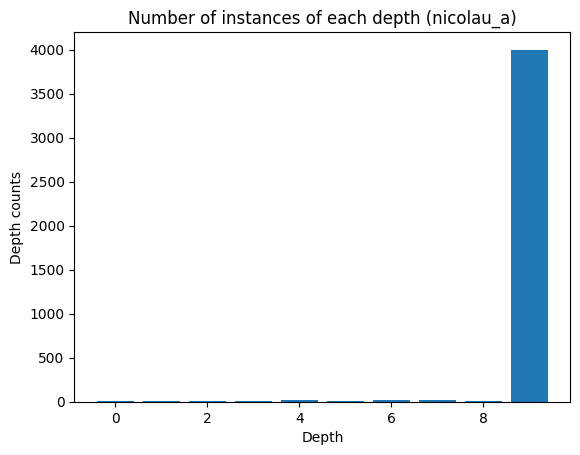

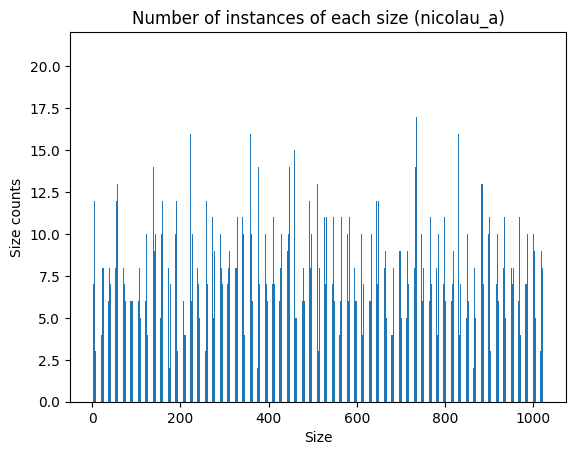

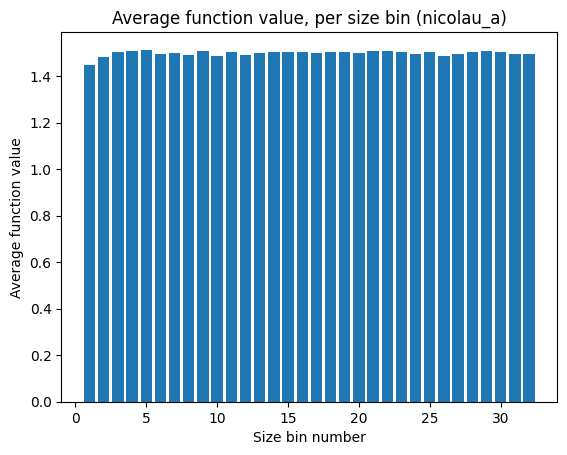

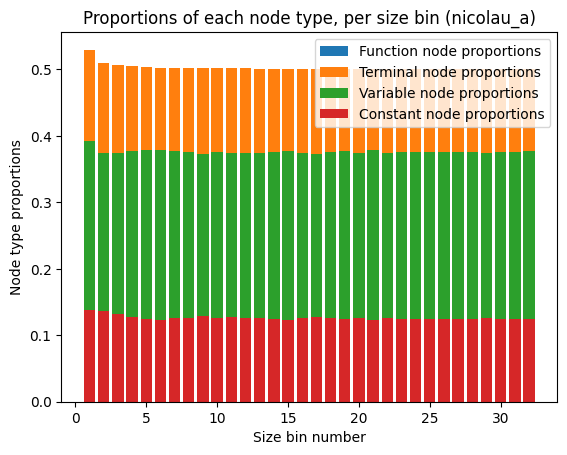

Function counts, bin 0: [64, 57, 59, 51, 48, 46]
Function counts, bin 1: [153, 170, 159, 133, 156, 146]
Function counts, bin 2: [226, 241, 231, 251, 259, 269]
Function counts, bin 3: [347, 365, 352, 403, 350, 369]
Function counts, bin 4: [493, 426, 461, 438, 492, 434]
Function counts, bin 5: [546, 551, 548, 563, 559, 583]
Function counts, bin 6: [605, 641, 654, 667, 661, 712]
Function counts, bin 7: [680, 658, 774, 789, 761, 825]
Function counts, bin 8: [779, 768, 884, 897, 904, 886]
Function counts, bin 9: [803, 801, 1039, 1010, 1020, 977]
Function counts, bin 10: [945, 818, 1142, 1119, 1140, 1075]
Function counts, bin 11: [914, 935, 1230, 1241, 1269, 1208]
Function counts, bin 12: [898, 943, 1358, 1354, 1403, 1340]
Function counts, bin 13: [971, 966, 1524, 1474, 1487, 1464]
Function counts, bin 14: [849, 927, 1587, 1634, 1642, 1639]
Function counts, bin 15: [805, 822, 1773, 1748, 1813, 1775]
Function counts, bin 16: [1148, 1185, 1788, 1812, 1832, 1819]
Function counts, bin 17: [1151,

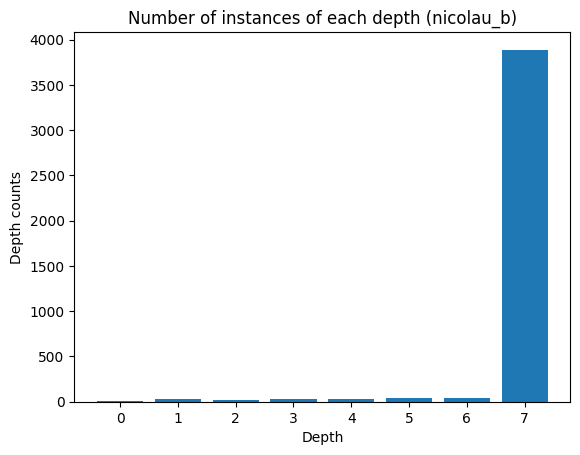

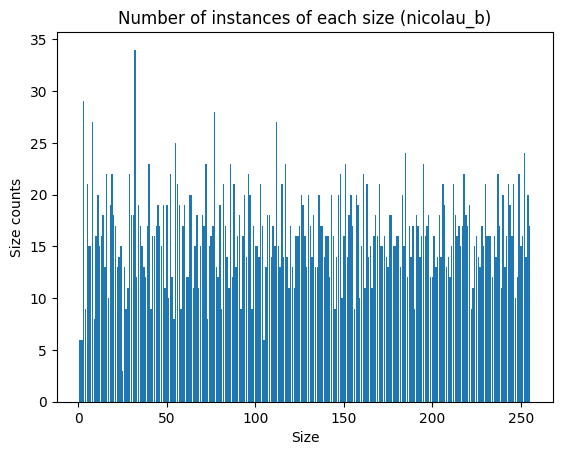

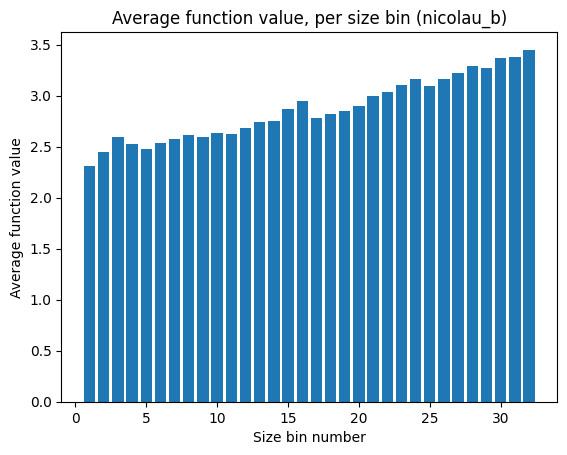

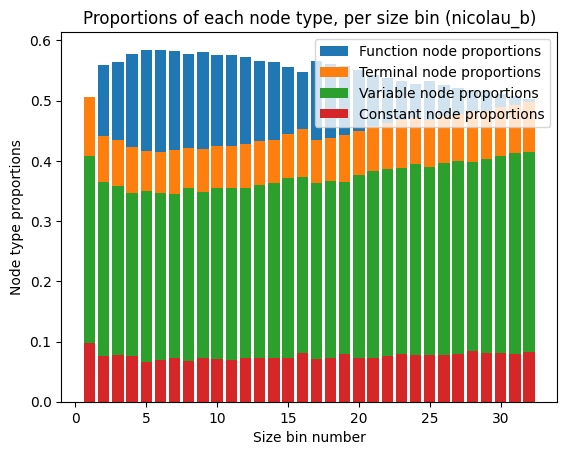

Function counts, bin 0: [20, 28, 20, 28, 22, 19, 12, 22, 23]
Function counts, bin 1: [68, 40, 63, 62, 65, 44, 67, 53, 56]
Function counts, bin 2: [88, 99, 107, 87, 83, 95, 106, 108, 85]
Function counts, bin 3: [128, 122, 132, 143, 136, 125, 132, 147, 141]
Function counts, bin 4: [159, 151, 166, 144, 160, 188, 165, 188, 207]
Function counts, bin 5: [179, 165, 188, 203, 199, 245, 241, 218, 216]
Function counts, bin 6: [202, 183, 228, 199, 198, 276, 281, 298, 296]
Function counts, bin 7: [206, 207, 198, 161, 201, 359, 347, 371, 329]
Function counts, bin 8: [221, 221, 190, 251, 222, 402, 376, 389, 428]
Function counts, bin 9: [238, 228, 234, 250, 221, 488, 447, 443, 441]
Function counts, bin 10: [244, 227, 227, 245, 232, 501, 513, 539, 522]
Function counts, bin 11: [211, 199, 198, 198, 204, 593, 581, 620, 607]
Function counts, bin 12: [220, 207, 213, 215, 232, 705, 652, 660, 605]
Function counts, bin 13: [172, 182, 196, 180, 181, 743, 729, 779, 719]
Function counts, bin 14: [162, 190, 171,

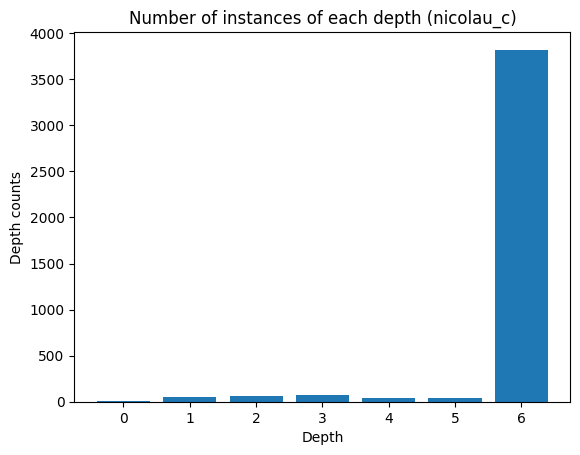

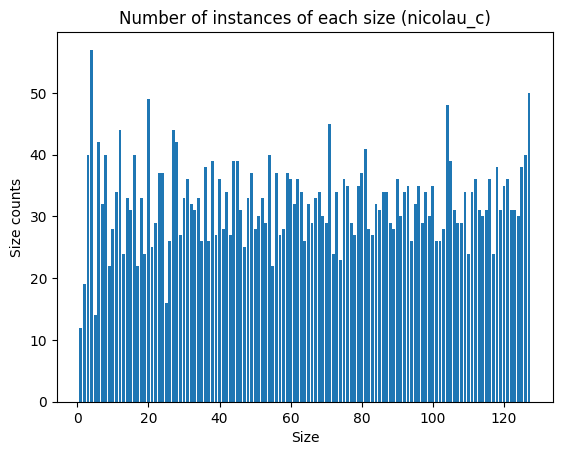

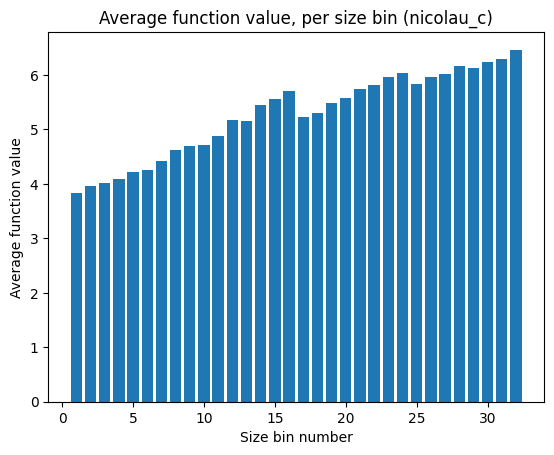

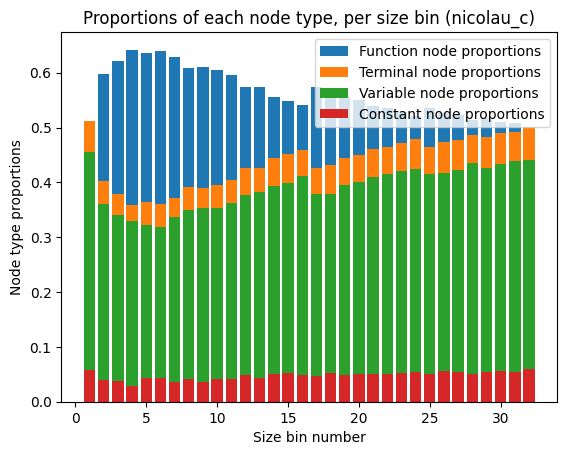

In [2]:
# Compute some statistics for the set of random programs
# generated for each function set.

# Total number of nodes for each size bin, for each function set.
num_nodes = []

for name, (num_functions, max_depth, max_size, bin_size) in (
    function_sets.items()):
    # For each function set...

    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # List where the `i`-th element, `0 <= i <= max_depth`, 
    # is to represent the number of instances for depth `i` 
    # over all random programs (i.e., from all size bins) 
    # for the function set with name `name`.
    depth_counts = [0]*(max_depth+1)

    # List where the `i`-th element, `0 <= i <= max_size-1`, 
    # is to represent the number of instances for size `i+1` 
    # over all random programs (i.e., from all size bins) 
    # for the function set with name `name`.
    size_counts = [0]*(max_size)

    # Lists where the `i`-th element contains the proportion
    # of the total number of nodes for size bin `i` that are 
    # functions/variables/constants/terminals.
    function_node_proportions = []
    variable_node_proportions = []
    constant_node_proportions = []
    terminal_node_proportions = []
    
    # List where the `i`-th element is to represent the 
    # "average function value" for size bin `i`, where 
    # this value is defined here to be the sum of the 
    # numbers of instances of each function type, with 
    # the `i`-th function type (specified by the `function_
    # counts` list) multiplied by `i`, all divided by the 
    # number of function types.
    #
    # In general, if the numbers of instances of function 
    # types are uniformly distributed for each size bin, 
    # the "average function value" as defined above should 
    # be equal to the number of function types minus one,
    # divided by 2. Thus, we can check for such uniformity
    # for each size bin by inspecting such an average value.
    average_function_values = []

    # Prepare for sizes related to the function set.
    num_nodes.append([])

    # Results of chi-square tests for each bin of the function set.
    chi_square = [[]]

    # Compute the relevant list elements.
    for i, (programs, depths, sizes, function_counts, 
        variable_counts, constant_counts) in enumerate(program_dict[name]
            [0:num_size_bins]):

        for depth in depths: depth_counts[depth] += 1
        for size in sizes: size_counts[size-1] += 1

        function_node_sum = sum(function_counts)
        variable_node_sum = sum(variable_counts)
        constant_node_sum = sum(constant_counts)
        terminal_node_sum = variable_node_sum + constant_node_sum
        node_sum = function_node_sum + terminal_node_sum

        function_node_proportions.append(function_node_sum/node_sum)
        variable_node_proportions.append(variable_node_sum/node_sum)
        constant_node_proportions.append(constant_node_sum/node_sum)
        terminal_node_proportions.append(terminal_node_sum/node_sum)
 
        average_function_value = (0) if (function_node_sum == 0) else (
            sum([i*function_counts[i] for i in range(
                num_functions)])/function_node_sum)

        average_function_values.append(average_function_value)

        # Add total number of nodes for the current size bin.
        num_nodes[-1].append(sum(sizes))

        # P-value for one-way chi-square test, performed for 
        # each set of function counts.
        _, p = stats.chisquare(function_counts)
        chi_square[-1].append(p)

        print(f'Function counts, bin {i}: {function_counts}')

    print(f'Chi-square p-values: {chi_square[-1]}')
    print(f'Minimum chi-square p-value: {min(chi_square[-1])}')
    print(f'Average chi-square p-value: {np.mean(chi_square[-1])}')

    # Compute/plot some relevant statistics for the number 
    # of instances of each possible program depth.

    # print('Program depths: ', depth_counts)
    # print('Mean of depth counts: ', np.mean(depth_counts))
    # print('Variance of depth counts: ', np.var(depth_counts))
    # print('Standard deviation of depth counts: ', np.std(depth_counts))
    # print(stats.chisquare(depth_counts))

    # Plot bar graph of depth counts.
    index = range(0, max_depth+1)
    plt.bar(index, depth_counts)
    plt.xlabel('Depth')
    plt.ylabel('Depth counts')
    plt.title('Number of instances of each depth ('+name+')')
    plt.savefig(f'{graphics_dir}/{name}/depths.svg')
    plt.show()


    # Compute/plot some relevant statistics for the number 
    # of instances of each possible program size.

    # print('Program sizes: ', size_counts)
    # print('Mean of size counts: ', np.mean(size_counts))
    # print('Variance of size counts: ', np.var(size_counts))
    # print('Standard deviation of size counts: ', np.std(size_counts))
    # print(stats.chisquare(size_counts))

    # Plot bar graph of size counts.
    index = range(1, max_size+1)
    plt.bar(index, size_counts)
    plt.xlabel('Size')
    plt.ylabel('Size counts')
    plt.title('Number of instances of each size ('+name+')')
    plt.savefig(f'{graphics_dir}/{name}/sizes.svg')
    plt.show()


    # Compute/plot some relevant statistics for the average
    # function values.

    # print('Average function values: ', average_function_values)
    # print('Mean of average function values: ', 
    #     np.mean(average_function_values))
    # print('Variance of average function values: ', 
    #     np.var(average_function_values))
    # print('Standard deviation of average function values: ', 
    #     np.std(average_function_values))
    # print(f'\n\nAverage function values: {average_function_values}\n\n')
    # print(stats.chisquare(average_function_values))

    # Plot bar graph of average function values.
    index = range(1, num_size_bins+1)

    #log_approx = [4*(1/log(max_size,2))*log(max_size/x,2) + 
    #    10.5*(1/log(max_size,2))*log(x, 2) for x in index]

    #plt.plot(index, log_approx)
    plt.bar(index, average_function_values)

    plt.xlabel('Size bin number')
    plt.ylabel('Average function value')
    plt.title('Average function value, per size bin ('+name+')')
    plt.savefig(f'{graphics_dir}/{name}/average_function_values.svg')
    plt.show()


    # Compute/plot some relevant statistics for proportions
    # of the total number of nodes with particular node types.

    # print('Function node proportions: ', function_node_proportions)
    # print('Terminal node proportions: ', terminal_node_proportions)
    # print('Variable node proportions: ', variable_node_proportions)
    # print('Constant node proportions: ', constant_node_proportions)


    # Plot bar graph of function counts.
    index = range(1, num_size_bins+1)
    plt.bar(index, function_node_proportions, 
        label='Function node proportions')
    plt.bar(index, terminal_node_proportions, 
        label='Terminal node proportions')
    plt.bar(index, variable_node_proportions, 
        label='Variable node proportions')
    plt.bar(index, constant_node_proportions, 
        label='Constant node proportions')
    plt.xlabel('Size bin number')
    plt.ylabel('Node type proportions')
    plt.title('Proportions of each node type, per size bin ('+name+')')
    plt.legend(loc='upper right')
    plt.savefig(f'{graphics_dir}/{name}/node_proportions.svg')
    plt.show()

In [3]:
# Average of *median average runtimes* for each size bin,
# for each number of fitness cases, for each function set,
# for each tool.
avg_med_avg_runtimes = []

# Median of *median average runtimes* for each size bin,
# for each number of fitness cases, for each function set,
# for each tool.
med_med_avg_runtimes = []

# Minimum of *median average runtimes* for each size bin,
# for each number of fitness cases, for each function set,
# for each tool.
min_med_avg_runtimes = []

# Maximum of *median average runtimes* for each size bin,
# for each number of fitness cases, for each function set,
# for each tool.
max_med_avg_runtimes = []

# Standard deviation of *median average runtimes* for each size 
# bin, for each number of fitness cases, for each function set,
# for each tool.
std_dev_med_avg_runtimes = []

# Interquartile range of *median average runtimes* for each size 
# bin, for each number of fitness cases, for each function set,
# for each tool.
iqr_med_avg_runtimes = []

# Median node evaluations per second (NEPS) from *median average
# runtimes* for each size bin, for each number of fitness cases, 
# for each function set, for each tool.
med_neps = []

# Median of median node evaluations per second (NEPS) for each 
# size bin, for each number of fitness cases, for each function 
# set, for each tool.
med_med_neps = []

# Interquartile range of median node evaluations per second (NEPS) 
# for each size bin, for each number of fitness cases, for each 
# function set, for each tool.
iqr_med_neps = []

In [4]:
####################################################################

# Compute statistics for DEAP.

with open(f'{root_dir}/results_deap.pkl', 'rb') as f:
    _, med_avg_runtimes = pickle.load(f)

# Prepare for statistics related to the tool.
avg_med_avg_runtimes.append([])
med_med_avg_runtimes.append([])
min_med_avg_runtimes.append([])
max_med_avg_runtimes.append([])
std_dev_med_avg_runtimes.append([])
iqr_med_avg_runtimes.append([])
med_neps.append([])
med_med_neps.append([])
iqr_med_neps.append([])

for i, (name, (num_functions, max_depth, max_size, bin_size)) in enumerate(
    function_sets.items()):
    # For each function set...
    print(f'For function set `{name}`...')

    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics related to the function set.
    avg_med_avg_runtimes[-1].append([])
    med_med_avg_runtimes[-1].append([])
    min_med_avg_runtimes[-1].append([])
    max_med_avg_runtimes[-1].append([])
    std_dev_med_avg_runtimes[-1].append([])
    iqr_med_avg_runtimes[-1].append([])
    med_neps[-1].append([])
    med_med_neps[-1].append([])
    iqr_med_neps[-1].append([])

    for j, nfc in enumerate(num_fitness_cases):
        # For each number of fitness cases...
        print(f'For number of fitness cases `{nfc}`...')

        # Average of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        avg_med_avg_runtimes[-1][-1].append(
            [np.mean(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Averages of median average runtimes:', 
            avg_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Median of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        med_med_avg_runtimes[-1][-1].append(
            [np.median(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Medians of median average runtimes:', 
            med_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Minimum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        min_med_avg_runtimes[-1][-1].append(
            [min(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Minimums of median average runtimes:', 
            min_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Maximum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        max_med_avg_runtimes[-1][-1].append(
            [max(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Maximums of median average runtimes:', 
            max_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Standard deviation of *median average runtimes* for each 
        # size bin, relevant to the number of fitness cases.
        std_dev_med_avg_runtimes[-1][-1].append(
            [np.std(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Standard deviations of median average runtimes:', 
            std_dev_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Interquartile range of *median average runtimes* for each 
        # size bin, relevant to the number of fitness cases.
        iqr_med_avg_runtimes[-1][-1].append(
            [stats.iqr(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Interquartile range of median average runtimes:', 
            iqr_med_avg_runtimes[-1][-1][-1])
        print('\n\n')

        print('Number of nodes per size bin:', num_nodes[i])

        # Number of node evaluations per size bin.
        num_evals = [(n * nfc) for n in num_nodes[i]]

        print('Number of node evaluations per size bin:', num_evals)

        # Median node evaluations per second (NEPS) from *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_neps[-1][-1].append([[num_evals_ / med_avg_runtime
            for med_avg_runtime in med_avg_runtimes[i][j][k]]
            for k, num_evals_ in enumerate(num_evals)])
        print('Median node evaluations per second:', med_neps[-1][-1][-1])
        print('\n')

        # Median node evaluations per second (NEPS) of *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_med_neps[-1][-1].append([np.median(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Median of median node evaluations per second:', 
            med_med_neps[-1][-1][-1])
        print('\n')

        # Interquartile range of median node evaluations per second 
        # (NEPS), for each size bin, relevant to the number of fitness 
        # cases.
        iqr_med_neps[-1][-1].append([stats.iqr(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Interquartile range of median node evaluations per second:', 
            iqr_med_neps[-1][-1][-1])
        print('\n')

        # Minimum median NEPS value.
        print('Minimum median NEPS value', min(med_med_neps[-1][-1][-1]))

        # Maximum median NEPS value.
        print('Maximum median NEPS value', max(med_med_neps[-1][-1][-1]))

For function set `nicolau_a`...
For number of fitness cases `10`...
Averages of median average runtimes: [0.1716427579522133, 0.20687837153673172, 0.24144501239061356, 0.274872250854969, 0.3044264018535614, 0.3553827032446861, 0.37811457365751266, 0.41034917533397675, 0.444672055542469, 0.4796822592616081, 0.5286800563335419, 0.5432741641998291, 0.5879908576607704, 0.6161500066518784, 0.6477785930037498, 0.7004386782646179, 0.7244725972414017, 0.7543257474899292, 0.786426231265068, 0.8526984602212906, 0.8893931731581688, 0.8875871375203133, 0.9358799830079079, 0.9660940542817116, 0.9688698947429657, 1.049866646528244, 1.0637950971722603, 1.093686893582344, 1.1373382583260536, 1.1509008929133415, 1.1837274134159088, 1.2322083711624146]


Medians of median average runtimes: [0.1716427579522133, 0.20687837153673172, 0.24144501239061356, 0.274872250854969, 0.3044264018535614, 0.3553827032446861, 0.37811457365751266, 0.41034917533397675, 0.444672055542469, 0.4796822592616081, 0.528680056333

In [5]:
####################################################################

# Compute statistics for TensorGP.

with open(f'{root_dir}/results_tensorgp.pkl', 'rb') as f:
    med_avg_runtimes = pickle.load(f)

for i, device in enumerate(('CPU', 'GPU')):
    # For each device...
    print(f'For device `{device}`...')

    # Prepare for statistics related to the tool.
    avg_med_avg_runtimes.append([])
    med_med_avg_runtimes.append([])
    min_med_avg_runtimes.append([])
    max_med_avg_runtimes.append([])
    std_dev_med_avg_runtimes.append([])
    iqr_med_avg_runtimes.append([])
    med_neps.append([])
    med_med_neps.append([])
    iqr_med_neps.append([])

    for j, (name, (num_functions, max_depth, max_size, bin_size)) in enumerate(
        function_sets.items()):
        # For each function set...
        print(f'For function set `{name}`...')

        # Number of "size bins."
        num_size_bins = int(math.ceil(max_size/bin_size))

        # Prepare for statistics related to the function set.
        avg_med_avg_runtimes[-1].append([])
        med_med_avg_runtimes[-1].append([])
        min_med_avg_runtimes[-1].append([])
        max_med_avg_runtimes[-1].append([])
        std_dev_med_avg_runtimes[-1].append([])
        iqr_med_avg_runtimes[-1].append([])
        med_neps[-1].append([])
        med_med_neps[-1].append([])
        iqr_med_neps[-1].append([])

        for k, nfc in enumerate(num_fitness_cases):
            # For each number of fitness cases...
            print(f'For number of fitness cases `{nfc}`...')


            # Average of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            avg_med_avg_runtimes[-1][-1].append(
                [np.mean(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Averages of median average runtimes:', 
                avg_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Median of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            med_med_avg_runtimes[-1][-1].append(
                [np.median(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Medians of median average runtimes:', 
                med_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Minimum of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            min_med_avg_runtimes[-1][-1].append(
                [min(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Minimums of median average runtimes:', 
                min_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Maximum of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            max_med_avg_runtimes[-1][-1].append(
                [max(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Maximums of median average runtimes:', 
                max_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Standard deviation of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            std_dev_med_avg_runtimes[-1][-1].append(
                [np.std(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Standard deviations of median average runtimes:', 
                std_dev_med_avg_runtimes[-1][-1][-1])
            print('\n')

            # Interquartile range of *median average runtimes* for each size bin,
            # relevant to the number of fitness cases.
            iqr_med_avg_runtimes[-1][-1].append(
                [stats.iqr(med_avg_runtimes[i][j][k][m]) 
                for m in range(num_size_bins)])
            print('Interquartile range of median average runtimes:', 
                iqr_med_avg_runtimes[-1][-1][-1])
            print('\n\n')

            print('Number of nodes per size bin:', num_nodes[j])

            # Number of node evaluations per size bin.
            num_evals = [(n * nfc) for n in num_nodes[j]]

            print('Number of node evaluations per size bin:', num_evals)

            # Median node evaluations per second (NEPS) from *median 
            # average runtimes*, for each size bin, relevant to the 
            # number of fitness cases.
            med_neps[-1][-1].append([[num_evals_ / med_avg_runtime
                for med_avg_runtime in med_avg_runtimes[i][j][k][m]]
                for m, num_evals_ in enumerate(num_evals)])
            print('Median node evaluations per second:', 
                med_neps[-1][-1][-1])
            print('\n')

            # Median node evaluations per second (NEPS) of *median 
            # average runtimes*, for each size bin, relevant to the 
            # number of fitness cases.
            med_med_neps[-1][-1].append([np.median(med_neps_) 
                for med_neps_ in med_neps[-1][-1][-1]])
            print('Median of median node evaluations per second:', 
                med_med_neps[-1][-1][-1])
            print('\n')

            # Interquartile range of median node evaluations per 
            # second (NEPS), for each size bin, relevant to the number 
            # of fitness cases.
            iqr_med_neps[-1][-1].append([stats.iqr(med_neps_) 
                for med_neps_ in med_neps[-1][-1][-1]])
            print('Interquartile range of median node evaluations per second:', 
                iqr_med_neps[-1][-1][-1])
            print('\n')

For device `CPU`...
For function set `nicolau_a`...
For number of fitness cases `10`...
Averages of median average runtimes: [0.09747415781021118, 0.2223118096590042, 0.3318024054169655, 0.44771844893693924, 0.5625903606414795, 0.6784568578004837, 0.7955111488699913, 0.9092358946800232, 1.0329809710383415, 1.139181688427925, 1.261647842824459, 1.3667839094996452, 1.4806828051805496, 1.6139274016022682, 1.6927764490246773, 1.8302777037024498, 1.9512954950332642, 2.067853607237339, 2.1655863150954247, 2.293563589453697, 2.378232918679714, 2.5315048322081566, 2.6315464824438095, 2.73086965829134, 2.854880176484585, 2.9619602039456367, 3.1012117341160774, 3.2351255118846893, 3.3669172823429108, 3.4436531886458397, 3.5492868572473526, 3.659389019012451]


Medians of median average runtimes: [0.09747415781021118, 0.2223118096590042, 0.3318024054169655, 0.44771844893693924, 0.5625903606414795, 0.6784568578004837, 0.7955111488699913, 0.9092358946800232, 1.0329809710383415, 1.139181688427925, 1

In [6]:
####################################################################

# Compute statistics for Operon.

# Read in the median average runtime results from some 
# CSV files, and convert into another useful format.
med_avg_runtimes = []

for name, (num_functions, max_depth, 
        max_size, bin_size) in function_sets.items():
    
    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics relevant to the function set.
    med_avg_runtimes.append([])

    with open(f'{root_dir}/results_operon_{name}.csv', 'r') as f:
        lines = f.readlines()

    for nfc in num_fitness_cases:
        # Prepare for statistics relevant to the number
        # of fitness cases.
        med_avg_runtimes[-1].append([[] for _ in range(num_size_bins)])

        # Offset into the lines list.
        i = (int(math.log(nfc, 10)) - 1) * num_size_bins

        for j in range(1, num_size_bins + 1):
            # Number of decimal digits needed to represent `j`.
            d = int(math.ceil(math.log(j + 1, 10)))

            # String representing median average runtimes
            # for bin `j`, in terms of microseconds.
            runtimes_str = ''.join(lines[i+j-1].split())[(5+d):]

            # Median average runtimes for bin `j`, in terms
            # of seconds.
            runtimes = [float(t)/(10**6) for t in runtimes_str.split(',')]

            med_avg_runtimes[-1][-1][j-1] = runtimes

# Prepare for statistics related to the tool.
avg_med_avg_runtimes.append([])
med_med_avg_runtimes.append([])
min_med_avg_runtimes.append([])
max_med_avg_runtimes.append([])
std_dev_med_avg_runtimes.append([])
iqr_med_avg_runtimes.append([])
med_neps.append([])
med_med_neps.append([])
iqr_med_neps.append([])

for i, (name, (num_functions, max_depth, max_size, bin_size)) in enumerate(
    function_sets.items()):
    # For each function set...
    print(f'For function set `{name}`...')

    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics related to the function set.
    avg_med_avg_runtimes[-1].append([])
    med_med_avg_runtimes[-1].append([])
    min_med_avg_runtimes[-1].append([])
    max_med_avg_runtimes[-1].append([])
    std_dev_med_avg_runtimes[-1].append([])
    iqr_med_avg_runtimes[-1].append([])
    med_neps[-1].append([])
    med_med_neps[-1].append([])
    iqr_med_neps[-1].append([])

    for j, nfc in enumerate(num_fitness_cases):
        # For each number of fitness cases...
        print(f'For number of fitness cases `{nfc}`...')

        # Average of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        avg_med_avg_runtimes[-1][-1].append(
            [np.mean(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Averages of median average runtimes:', 
            avg_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Median of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        med_med_avg_runtimes[-1][-1].append(
            [np.median(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Medians of median average runtimes:', 
            med_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Minimum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        min_med_avg_runtimes[-1][-1].append(
            [min(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Minimums of median average runtimes:', 
            min_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Maximum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        max_med_avg_runtimes[-1][-1].append(
            [max(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Maximums of median average runtimes:', 
            max_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Standard deviation of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        std_dev_med_avg_runtimes[-1][-1].append(
            [np.std(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Standard deviations of median average runtimes:', 
            std_dev_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Interquartile range of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        iqr_med_avg_runtimes[-1][-1].append(
            [stats.iqr(med_avg_runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Interquartile range of median average runtimes:', 
            iqr_med_avg_runtimes[-1][-1][-1])
        print('\n\n')

        print('Number of nodes per size bin:', num_nodes[i])

        # Number of node evaluations per size bin.
        num_evals = [(n * nfc) for n in num_nodes[i]]

        print('Number of node evaluations per size bin:', num_evals)

        # Median node evaluations per second (NEPS) from *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_neps[-1][-1].append([[num_evals_ / med_avg_runtime
            for med_avg_runtime in med_avg_runtimes[i][j][k]]
            for k, num_evals_ in enumerate(num_evals)])
        print('Median node evaluations per second:', med_neps[-1][-1][-1])
        print('\n')

        # Median node evaluations per second (NEPS) of *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_med_neps[-1][-1].append([np.median(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Median of median node evaluations per second:', 
            med_med_neps[-1][-1][-1])
        print('\n')

        # Interquartile range of median node evaluations per second 
        # (NEPS), for each size bin, relevant to the number of fitness 
        # cases.
        iqr_med_neps[-1][-1].append([stats.iqr(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Interquartile range of median node evaluations per second:', 
            iqr_med_neps[-1][-1][-1])
        print('\n')

        # Minimum median NEPS value.
        print('Minimum median NEPS value', min(med_med_neps[-1][-1][-1]))

        # Maximum median NEPS value.
        print('Maximum median NEPS value', max(med_med_neps[-1][-1][-1]))

For function set `nicolau_a`...
For number of fitness cases `10`...
Averages of median average runtimes: [6.450446499999999e-05, 8.244121300000001e-05, 0.00010110423900000001, 0.00011453576599999999, 0.000128902121, 0.000144030403, 0.000161678417, 0.00018197111, 0.000206659515, 3.4218845e-05, 0.000252371427, 0.000292927365, 0.00031560048899999997, 0.000364061199, 0.000341915656, 0.000429319514, 0.000452024702, 0.000452241508, 0.0005372216529999999, 0.000543210393, 0.000527721223, 0.000656554247, 0.000555853826, 0.000694221867, 0.000690028412, 0.00071767766, 0.0007057321359999999, 0.000772805612, 0.000827065522, 0.000869041322, 0.000864417408, 0.000901990864]


Medians of median average runtimes: [6.450446499999999e-05, 8.244121300000001e-05, 0.00010110423900000001, 0.00011453576599999999, 0.000128902121, 0.000144030403, 0.000161678417, 0.00018197111, 0.000206659515, 3.4218845e-05, 0.000252371427, 0.000292927365, 0.00031560048899999997, 0.000364061199, 0.000341915656, 0.000429319514, 0.

In [7]:
####################################################################

# Compute statistics for FPGA.

# Runtimes for FPGA.
runtimes = []

for name, (num_functions, max_depth, 
        max_size, bin_size) in function_sets.items():
    
    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics relevant to the function set.
    runtimes.append([])

    for nfc in num_fitness_cases:
        with open(f'{root_dir}/performance_counts/{name}/{nfc}.txt', 'r') as f:
            # Lines of the current file.
            lines = f.readlines()

            # Clock frequency for specified run.
            clock_freq = float(lines[0])*1e6

            # Runtimes relevant to the number of fitness cases.
            runtimes[-1].append([[float(lines[i])/clock_freq] 
                for i in range(1, num_size_bins+1)])

# Prepare for statistics related to the tool.
avg_med_avg_runtimes.append([])
med_med_avg_runtimes.append([])
min_med_avg_runtimes.append([])
max_med_avg_runtimes.append([])
std_dev_med_avg_runtimes.append([])
iqr_med_avg_runtimes.append([])
med_neps.append([])
med_med_neps.append([])
iqr_med_neps.append([])

for i, (name, (num_functions, max_depth, max_size, bin_size)) in enumerate(
    function_sets.items()):
    # For each function set...
    print(f'For function set `{name}`...')

    # Number of "size bins."
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Prepare for statistics related to the function set.
    avg_med_avg_runtimes[-1].append([])
    med_med_avg_runtimes[-1].append([])
    min_med_avg_runtimes[-1].append([])
    max_med_avg_runtimes[-1].append([])
    std_dev_med_avg_runtimes[-1].append([])
    iqr_med_avg_runtimes[-1].append([])
    med_neps[-1].append([])
    med_med_neps[-1].append([])
    iqr_med_neps[-1].append([])

    for j, nfc in enumerate(num_fitness_cases):
        # For each number of fitness cases...
        print(f'For number of fitness cases `{nfc}`...')

        # Average of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        avg_med_avg_runtimes[-1][-1].append(
            [np.mean(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Averages of median average runtimes:', 
            avg_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Median of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        med_med_avg_runtimes[-1][-1].append(
            [np.median(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Medians of median average runtimes:', 
            med_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Minimum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        min_med_avg_runtimes[-1][-1].append(
            [min(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Minimums of median average runtimes:', 
            min_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Maximum of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        max_med_avg_runtimes[-1][-1].append(
            [max(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Maximums of median average runtimes:', 
            max_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Standard deviation of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        std_dev_med_avg_runtimes[-1][-1].append(
            [np.std(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Standard deviations of median average runtimes:', 
            std_dev_med_avg_runtimes[-1][-1][-1])
        print('\n')

        # Interquartile range of *median average runtimes* for each size bin,
        # relevant to the number of fitness cases.
        iqr_med_avg_runtimes[-1][-1].append(
            [stats.iqr(runtimes[i][j][k]) 
            for k in range(num_size_bins)])
        print('Interquartile range of median average runtimes:', 
            iqr_med_avg_runtimes[-1][-1][-1])
        print('\n\n')

        print('Number of nodes per size bin:', num_nodes[i])

        # Number of node evaluations per size bin.
        num_evals = [(n * nfc) for n in num_nodes[i]]

        print('Number of node evaluations per size bin:', num_evals)

        # Median node evaluations per second (NEPS) from *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_neps[-1][-1].append([[num_evals_ / runtime
            for runtime in runtimes[i][j][k]]
            for k, num_evals_ in enumerate(num_evals)])
        print('Median node evaluations per second:', med_neps[-1][-1][-1])
        print('\n')

        # Median node evaluations per second (NEPS) of *median 
        # average runtimes*, for each size bin, relevant to the 
        # number of fitness cases.
        med_med_neps[-1][-1].append([np.median(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Median of median node evaluations per second:', 
            med_med_neps[-1][-1][-1])
        print('\n')

        # Interquartile range of median node evaluations per second 
        # (NEPS), for each size bin, relevant to the number of fitness 
        # cases.
        iqr_med_neps[-1][-1].append([stats.iqr(med_neps_)
            for med_neps_ in med_neps[-1][-1][-1]])
        print('Interquartile range of median node evaluations per second:', 
            iqr_med_neps[-1][-1][-1])
        print('\n')

        # Minimum median NEPS value.
        print('Minimum median NEPS value', min(med_med_neps[-1][-1][-1]))

        # Maximum median NEPS value.
        print('Maximum median NEPS value', max(med_med_neps[-1][-1][-1]))

For function set `nicolau_a`...
For number of fitness cases `10`...
Averages of median average runtimes: [2.9117826861228503e-05, 6.205866978532636e-05, 9.074679495698554e-05, 0.00011976273378872852, 0.00014972224437179385, 0.00017792307896765275, 0.00020547271615766952, 0.00023565815237133313, 0.0002648202783758162, 0.000294939265874598, 0.0003236539705322099, 0.0003531040409678477, 0.00038147321230807397, 0.0004096961964755602, 0.00043983290363164377, 0.0004682065048861955, 0.0004979002206097334, 0.0005306107079889075, 0.0005589621596718319, 0.0005872958916974545, 0.000617547776626, 0.0006454695266193552, 0.000674135502219387, 0.0007038203581142741, 0.0007318882952803693, 0.0007623040870389567, 0.0007905049216348156, 0.0008198708236982696, 0.000848598818098858, 0.0008783412628799759, 0.000906679424819924, 0.0009338835286925551]


Medians of median average runtimes: [2.9117826861228503e-05, 6.205866978532636e-05, 9.074679495698554e-05, 0.00011976273378872852, 0.00014972224437179385, 0

In [8]:
# # Plot graph of median average runtimes for each tool, 
# # for each number of fitness cases, for each function set.
# for i, (name, (_, _, max_size, bin_size)) in enumerate(
#     function_sets.items()):

#     # Number of size bins.
#     num_size_bins = int(math.ceil(max_size/bin_size))

#     # Index range for plot.
#     index = [(bin_size * i) for i in range(1, num_size_bins+1)]

#     for j, nfc in enumerate(num_fitness_cases):
#         for t, tool in enumerate(tools):
#             x = index
#             y = med_med_avg_runtimes[t][i][j]
#             iqr = iqr_med_avg_runtimes[t][i][j]
#             # max_iqr_percentage = [
#             lower_bound = [y_ - iqr_ for y_, iqr_ in zip(y, iqr)]
#             upper_bound = [y_ + iqr_ for y_, iqr_ in zip(y, iqr)]
#             plt.plot(x, y, label=f'{tool}')
#             plt.fill_between(x, lower_bound, upper_bound, color='bisque')
#         plt.xlabel('Maximum program size (bin number)')
#         # plt.xticks(index, [str(size) for size in program_sizes[i]])
#         # plt.locator_params(axis='x', nbins=15)
#         plt.ylabel('Median average runtime')
#         plt.yscale('log')
#         plt.title(
#             f'Median Average Runtime vs. Max. Program Size '
#             f'({nfc} f.c., {name})')
#         plt.legend(loc='upper left')
#         plt.savefig(f'{graphics_dir}/{name}/median_avg_runtime_{nfc}.svg')
#         plt.show()

In [9]:
colors = ('tab:cyan', 'tab:purple', 'tab:blue', 'tab:green', 'tab:red')
markers = ('x', '^', '.', 'd', '*')
marker_sizes = (6, 4, 8, 5, 9)
# fill_between = (True, True, True, True, False)
print_legend = ((True, False, False, False, False),
                (False, False, False, False, False),
                (False, False, False, False, False))
# print_function_set = ('nicolau_a', 'nicolau_b')
# print_nfc = (10, 100000)
scale_text_x = ((205, 205, 205, 205, 205),
                (52, 52, 52, 52, 52),
                (25, 25, 25, 25, 25))
scale_text_y = ((0.5e9, 0.5e9, 0.5e9, 1.25e9, 6e8),
                (0.5e9, 0.5e9, 0.5e9, 1.25e9, 6e8),
                (0.45e9, 0.5e9, 0.5e9, 1.25e9, 5.5e8))
                
# median_runtimes = []
average_neps = []
median_neps = []

all_neps = [[], [], [], [], []]

# Plot graph of median node evaluations per second for each tool, 
# for each number of fitness cases, for each function set.
for i, (name, (_, _, max_size, bin_size)) in enumerate(
    function_sets.items()):

    # Prepare for average/median NEPS values for each number 
    # of fitness cases and each tool, for the current function set.
    # average_neps.append([[0]*5]*5)
    # median_neps.append([[0]*5]*5)
    # median_runtimes.append([])
    average_neps.append([])
    median_neps.append([])

    # Number of size bins.
    num_size_bins = int(math.ceil(max_size/bin_size))

    # Index range for plot.
    index = [(bin_size * i) for i in range(1, num_size_bins+1)]
    index_ = [i for i in range(1, num_size_bins+1)]

    for j, nfc in enumerate(num_fitness_cases):
        # median_runtimes[-1].append([])
        average_neps[-1].append([])
        median_neps[-1].append([])

        for t, tool in enumerate(tools):
            # median_runtimes[-1][-1].append([])
            average_neps[-1][-1].append([])
            median_neps[-1][-1].append([])

            x = index
            y = med_med_neps[t][i][j]
            # t = med_med_avg_runtimes[t][i][j]
            
            iqr = iqr_med_neps[t][i][j]
            lower_bound = [y_ - iqr_ for y_, iqr_ in zip(y, iqr)]
            upper_bound = [y_ + iqr_ for y_, iqr_ in zip(y, iqr)]

            # median_runtimes[-1][-1][-1] = np.median(t)
            average_neps[-1][-1][-1] = np.mean(y)
            median_neps[-1][-1][-1] = np.median(y)

            for neps in y:
                all_neps[t].append(neps)

            # plt.plot(
            #     x, y, label=f'{tool}', color=colors[t], marker=markers[t], 
            #     markersize=8, linestyle='None')
            # plt.axhline(y=1e9, color='gray', linestyle='dashed')


        # plt.text(
        #     scale_text_x[i][j], scale_text_y[i][j], '$10^9$ for scale', 
        #     weight='normal', fontsize = 11)

        # plt.xlabel('Bin number, maximum program size', fontsize=14)
        # plt.xticks(index, [f'{str(i_)}, {str(i)}' 
        #     for i, i_ in zip(index, index_)], fontsize=11)
        # plt.yticks(fontsize=11)
        # plt.locator_params(axis='x', nbins=6)
        # plt.ylabel('Node evaluations per second (NEPS)', fontsize=14)
        # plt.yscale('log')
        # if print_legend[i][j]:
        #     plt.legend(loc='center left')
        # plt.savefig(f'{graphics_dir}/{name}/median_neps_{nfc}.svg')
        # plt.savefig(
        #     f'{graphics_dir}/{name}/median_neps_{nfc}.png', 
        #     dpi=600)
        # plt.show()


# # Average NEPS for each tool.
# total_avg_neps = [np.mean([np.mean([average_neps[i][j][t] 
#     for j, _ in enumerate(num_fitness_cases)]) 
#     for i, _ in enumerate(function_sets.items())])
#     for t, _ in enumerate(tools)]

# # Average NEPS for each tool, for less than 1000 fitness cases.
# total_avg_neps_range = [[np.mean([np.mean([average_neps[i][j][t] 
#     for j, _ in enumerate(num_fitness_cases[:n+1])]) 
#     for i, _ in enumerate(function_sets.items())])
#     for t, _ in enumerate(tools)] for n, _ in enumerate(num_fitness_cases)]

# # Average NEPS for each tool, for less than 1000 fitness cases;
# # alternate method of calculating.
# # total_avg_neps_range_alt = [np.mean(all_neps[t]) for t in range(len(tools))]
# total_avg_neps_range_alt = [[np.mean([average_neps[i][j][t] 
#     for i, j in product(range(len(function_sets)), range(n+1))])
#     for t in range(len(tools))] for n in range(len(num_fitness_cases))] 
#     # for j, _ in enumerate(num_fitness_cases[:n+1])]) 
#     # for i, _ in enumerate(function_sets.items())])
#     # for t, _ in enumerate(tools)] for n, _ in enumerate(num_fitness_cases)]

# print(f'Total avg. NEPS: {total_avg_neps}')
# print(f'Total avg. NEPS (range): {total_avg_neps_range}')
# print(f'Total avg. NEPS (range, alternate): {total_avg_neps_range_alt}')
# # print(f'Alternate the same? '
# #       f'{any(a != b for a, b in zip(total_avg_neps_range, total_avg_neps_range_alt))}')



# # Calculate median speedup/slowdown for the FPGA.
# total_median_neps = [np.median([np.median([average_neps[i][j][t] 
#     for j, _ in enumerate(num_fitness_cases)]) 
#     for i, _ in enumerate(function_sets.items())])
#     for t, _ in enumerate(tools)]

# total_median_neps_range = [[np.median([np.median([average_neps[i][j][t] 
#     for j, _ in enumerate(num_fitness_cases[:n+1])]) 
#     for i, _ in enumerate(function_sets.items())])
#     for t, _ in enumerate(tools)] for n, _ in enumerate(num_fitness_cases)]

# avg_fpga_speedup = [total_avg_neps[4] / neps 
#     for neps in total_avg_neps[:4]]
    
# avg_fpga_speedup_range = [[total_avg_neps_range_alt[i][4] / neps 
#     for neps in total_avg_neps_range_alt[i][:4]] 
#     for i, _ in enumerate(num_fitness_cases)]

# median_fpga_speedup = [total_median_neps[4] / neps 
#     for neps in total_median_neps[:4]]

# median_fpga_speedup_range = [[total_median_neps_range[i][4] / neps 
#     for neps in total_median_neps_range[i][:4]] 
#     for i, _ in enumerate(num_fitness_cases)]


# print(f'Average FPGA speedup overall: {avg_fpga_speedup}')

# print(f'Average FPGA speedup range, for each threshold of fitness cases: '
#       f'{avg_fpga_speedup_range}')

# print(f'Median FPGA speedup: {median_fpga_speedup}')

# print(f'Median FPGA speedup range, for each threshold of fitness cases: '
#       f'{median_fpga_speedup_range}')

In [19]:
# Median runtimes for each number of fitness cases,
# for each tool, for each function set.
median_runtimes = []
for t, tool in enumerate(tools):
    median_runtimes.append([])
    for i, _ in enumerate(function_sets.items()):
        median_runtimes[-1].append([])
        for j, nfc in enumerate(num_fitness_cases):
            median_runtimes[-1][-1].append([])
            median_runtimes[-1][-1][-1] = np.median(
                med_med_avg_runtimes[t][i][j])
median_runtimes = np.asarray(median_runtimes)

print(f'Median runtimes:\n{median_runtimes}\n')
print(f'Median runtimes shape:\n{median_runtimes.shape}\n')

# Total median runtimes for each fitness case threshold,
# for each tool.
total_median_runtimes = np.asarray(
    [[np.sum(median_runtimes[t, :, :n+1])
        for n, _ in enumerate(num_fitness_cases)] 
            for t, _ in enumerate(tools)])

print(f'\nTotal median runtimes:\n{total_median_runtimes}\n')
print(f'\nTotal median runtimes shape:\n{total_median_runtimes.shape}\n')

num_nodes = np.asarray(num_nodes)
print(f'\nNum nodes:\n{num_nodes}\n')
print(f'\nNum nodes shape:\n{num_nodes.shape}\n')

# Total number of program nodes across all function sets,
# for each fitness case threshold.
total_nodes = np.asarray(
    [np.sum([fc * num_nodes for fc in num_fitness_cases[:n+1]])
        for n, _ in enumerate(num_fitness_cases)])

print(f'\nTotal nodes:\n{total_nodes}\n')
print(f'\nTotal nodes shape:\n{total_nodes.shape}\n')

# Total median NEPS for each fitness case threshold, for each tool.
total_neps = total_nodes / total_median_runtimes

print(f'\nTotal NEPS:\n{total_neps}\n')
print(f'\nTotal NEPS shape:\n{total_neps.shape}\n')

# Average FPGA speedup for each fitness case threshold.
avg_fpga_speedup = total_neps[-1, :] / total_neps[:-1, :]

print(f'\nAverage FPGA Speedup:\n{avg_fpga_speedup}\n')
print(f'\nAverage FPGA Speedup shape:\n{avg_fpga_speedup.shape}\n')

Median runtimes:
[[[7.12455638e-01 7.50896581e-01 1.01639321e+00 7.24942249e+00
   7.01021035e+01]
  [2.78395463e-01 2.84893237e-01 3.49018034e-01 2.05268477e+00
   1.92907529e+01]
  [2.58661818e-01 2.54673902e-01 2.79564217e-01 1.22032066e+00
   1.13518292e+01]]

 [[1.89078660e+00 1.90742232e+00 1.97902645e+00 2.25593315e+00
   4.51650576e+00]
  [4.77421828e-01 4.79588147e-01 5.04859500e-01 6.43246438e-01
   1.44208545e+00]
  [2.84268118e-01 2.91044142e-01 3.05400796e-01 4.73744065e-01
   9.38851766e-01]]

 [[2.32131780e+00 1.97637387e+00 2.07739416e+00 2.34382771e+00
   4.50755429e+00]
  [4.89831347e-01 4.93965860e-01 6.31718274e-01 6.44715391e-01
   1.48357106e+00]
  [2.94216719e-01 2.99308147e-01 3.15591682e-01 3.69414516e-01
   9.36159927e-01]]

 [[4.40672108e-04 4.23488969e-04 4.23488969e-04 1.21481128e-02
   1.14224932e-01]
  [1.88050340e-04 1.92961237e-04 1.92961237e-04 7.49862987e-03
   6.98220999e-02]
  [1.04698226e-04 1.07302877e-04 1.07302877e-04 2.71367948e-03
   2.5197017